In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
import random
from sklearn.base import clone
from decision_tree import *
from ga_methods import mutate, crossover
from ab_methods import adaboost_single_tree
from tqdm import tqdm

# data = load_digits()
data = load_breast_cancer()
X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape)
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))
p = 100     # number of hypotheses
r = 0.2    # fraction of crossover
m = 0.2    # mutation rate
step = 100   # number of steps
n_crossover = int(r*p)
assert n_crossover%2==0, "Odd n_crossover"
n_select = p - n_crossover
n_mutate = int(m*p)
print(f"Select {n_select} | Crossover {n_crossover} | Mutate {n_mutate}")

(455, 30) (114, 30)
(array([0, 1]), array([170, 285]))
(array([0, 1]), array([42, 72]))
Select 80 | Crossover 20 | Mutate 20


In [3]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([170, 285]))

In [4]:
def eval_model(clf, X, y):
    y_test_preds = clf.predict(X)
    test_acc = accuracy_score(y, y_test_preds)
    return test_acc
# Initial trees from bagging
bagging_clf = BaggingClassifier(n_estimators=p)
bagging_clf.fit(X_train, y_train)
print('Bagging accuracy: ', eval_model(bagging_clf, X_test, y_test))

Bagging accuracy:  0.9649122807017544


In [5]:
trees = bagging_clf.estimators_
trees = [construct_tree(t, X, y) for t in trees]
ga_acc_list = []
ab_acc_list = []
ga_select = []
ab_select = []
for i in tqdm(range(step)):
    # GA step
    ga_trees = []
    eval_results = np.asarray([eval_model(tree, X_test, y_test) for tree in trees])
    # select
    select_indices = eval_results.argsort()[-n_select:][::-1]
    for i in select_indices:
        ga_trees.append(trees[i])
    # crossover
    crossover_trees = []
    select_indices = eval_results.argsort()[-n_crossover:][::-1]
    for i in select_indices:
        crossover_trees.append(trees[i])
    random.shuffle(crossover_trees)
    for i in range(len(crossover_trees), 2):
        tree1 = crossover_trees[i]
        tree2 = crossover_trees[i+1]
        crossover_trees[i:(i+2)] = crossover(tree1, tree2)
    ga_trees.extend(crossover_trees)
    # mutate
    select_indices = random.sample(range(len(ga_trees)), n_mutate)
    for i in select_indices:
        mutate(ga_trees[i])

        
    # AdaBoost step
    ab_trees = [adaboost_single_tree(X_train, y_train, tree) for tree in trees]
                              
                              
    # combine tree
    forest = []
    forest.extend(ga_trees)
    forest.extend(ab_trees)
    forest_eval_results = np.asarray([eval_model(tree, X_test, y_test) for tree in forest])
    select_indices = forest_eval_results.argsort()[-p:][::-1]
    trees = [forest[i] for i in select_indices]
    ga_acc = round(forest_eval_results[:p].mean()*100, 2)
    ab_acc = round(forest_eval_results[p:].mean()*100, 2)
    ga_acc_list.append(ga_acc)
    ab_acc_list.append(ab_acc)
    ga_select.append(sum(forest_eval_results < p))
    ab_select.append(sum(forest_eval_results >= p))
gaen_y_test_preds = bagging_predict(trees, X_test)
gaen_acc = accuracy_score(y_test, gaen_y_test_preds)
print(round(gaen_acc*100, 2))

100%|██████████| 100/100 [01:13<00:00,  1.37it/s]

85.96


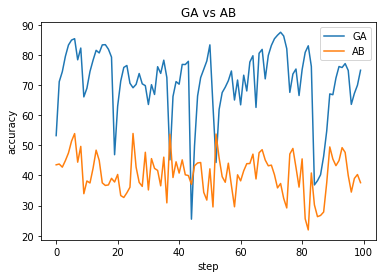

In [8]:
plt.plot(range(step), ga_acc_list, label = "GA")
plt.plot(range(step), ab_acc_list, label = "AB")
plt.xlabel('step')
# Set the y axis label of the current axis.
plt.ylabel('accuracy')
# Set a title of the current axes.
plt.title('GA vs AB')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

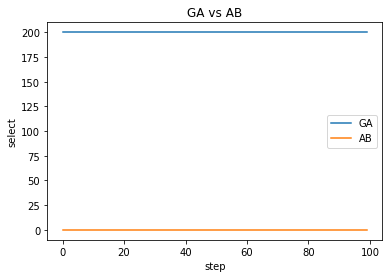

In [9]:
plt.plot(range(step), ga_select, label = "GA")
plt.plot(range(step), ab_select, label = "AB")
plt.xlabel('step')
# Set the y axis label of the current axis.
plt.ylabel('select')
# Set a title of the current axes.
plt.title('GA vs AB')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

# Todos
1. Performance of AdaBoost trees are terrible. Must find a way to get better AdaBoost trees.
2. Compare current implementation of genetic algorithm with the paper "Breeding ..."
3. More utility function (get_depth(), get_node_count(), etc.)